In [16]:
# Import packages
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import random
from scipy.optimize import fsolve
import scipy.optimize
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from KDEpy import FFTKDE

In [17]:
# Define the triply periodic minimal surface functions
def SchwarzD(X, period):

    N = 2*np.pi/period
    
    a = np.sin(N*X[0]) * np.sin(N*X[1]) * np.sin(N*X[2])
    b = np.sin(N*X[0]) * np.cos(N*X[1]) * np.cos(N*X[2])
    c = np.cos(N*X[0]) * np.sin(N*X[1]) * np.cos(N*X[2])
    d = np.cos(N*X[0]) * np.cos(N*X[1]) * np.sin(N*X[2])
    
    return a + b + c + d

def Gyroid(X,period):
    
    N = 2*np.pi/period
    
    a = np.sin(N*X[0]) * np.cos(N*X[1])
    b = np.sin(N*X[1]) * np.cos(N*X[2])
    c = np.sin(N*X[2]) * np.cos(N*X[0])
    
    return a + b + c

def SchwarzD_grad(v,period):
    
    x = v[0]; y = v[1]; z = v[2]
    N = 2*np.pi / period
    
    a = N*np.cos(N*x)*np.sin(N*y)*np.sin(N*z) + N*np.cos(N*x)*np.cos(N*y)*np.cos(N*z) - N*np.sin(N*x)*np.sin(N*y)*np.cos(N*z) - N*np.sin(N*x)*np.cos(N*y)*np.sin(N*z)
    b = N*np.sin(N*x)*np.cos(N*y)*np.sin(N*z) - N*np.sin(N*x)*np.sin(N*y)*np.cos(N*z) + N*np.cos(N*x)*np.cos(N*y)*np.cos(N*z) - N*np.cos(N*x)*np.sin(N*y)*np.sin(N*z)
    c = N*np.sin(N*x)*np.sin(N*y)*np.cos(N*z) - N*np.sin(N*x)*np.cos(N*y)*np.sin(N*z) - N*np.cos(N*x)*np.sin(N*y)*np.sin(N*z) + N*np.cos(N*x)*np.cos(N*y)*np.cos(N*z)
    
    return np.array([a,b,c]) / np.linalg.norm(np.array([a,b,c]))

def Gyroid_grad(v,period):
    
    x = v[0]; y = v[1]; z = v[2]
    N = 2*np.pi / period
    
    a =  N*np.cos(N*x)*np.cos(N*y) - N*np.sin(N*x)*np.sin(N*z)
    b = -N*np.sin(N*y)*np.sin(N*x) + N*np.cos(N*y)*np.cos(N*z)
    c = -N*np.sin(N*y)*np.sin(N*z) + N*np.cos(N*z)*np.cos(N*x)
    
    return np.array([a,b,c]) / np.linalg.norm(np.array([a,b,c]))

def Primitive(X, period):
    
    N = 2*np.pi/period
    
    a = np.cos(N*X[0]) + np.cos(N*X[1]) + np.cos(N*X[2])
    
    return a

def Primitive_grad(v, period):
    
    x = v[0]; y = v[1]; z = v[2]
    N = 2*np.pi / period
    
    a = -N*np.sin(N*x) 
    b = -N*np.sin(N*y) 
    c = -N*np.sin(N*z)
    
    return np.array([a,b,c]) / np.linalg.norm(np.array([a,b,c]))

In [18]:
# Functions for solving the equations
def P(t,X,period=9.4):
    n = Gyroid_grad(X,period)
    
    return X + t*n

# def Gyroid_eq(v, period=9.4):
    
#     normal = Gyroid_grad(v,period) # calculate the normal vector at the point
    
#     N = 2*np.pi / period
#     a = np.sin(N*v[0]) * np.cos(N*v[1])
#     b = np.sin(N*v[1]) * np.cos(N*v[2])
#     c = np.sin(N*v[2]) * np.cos(N*v[0])
    
#     print(a + b + c)
    
#     return lambda t : v + t*normal + a + b + c
    
def Gyroid_eq(X,period=9.4):

    n = Gyroid_grad(X,period)
    N = 2*np.pi/period
    
    return lambda t : np.sin(N * (X[0] + t*n[0])) * np.cos(N * (X[1] + t*n[1])) + np.sin(N * (X[1] + t*n[1])) * np.cos(N * (X[2] + t*n[2])) + np.sin(N * (X[2] + t*n[2])) * np.cos(N * (X[0] + t*n[0]))

def SchwarzD_eq(X,period=9.4):
    
    n = SchwarzD_grad(X,period)
    N = 2*np.pi/period
    
    return lambda t : np.sin(N * (X[0] + t*n[0])) * np.sin(N * (X[1] + t*n[1])) * np.sin(N * (X[2] + t*n[2])) + np.sin(N * (X[0] + t*n[0])) * np.cos(N * (X[1] + t*n[1])) * np.cos(N * (X[2] + t*n[2])) + np.cos(N * (X[0] + t*n[0])) * np.sin(N * (X[1] + t*n[1])) * np.cos(N * (X[2] + t*n[2])) + np.cos(N * (X[0] + t*n[0])) * np.cos(N * (X[1] + t*n[1])) * np.sin(N * (X[2] + t*n[2]))

def Primitive_eq(X,period=9.4):

    n = Primitive_grad(X,period)
    N = 2*np.pi/period
    
    return lambda t : np.cos(N * (X[0] + t*n[0])) + np.cos(N * (X[1] + t*n[1])) + np.cos(N * (X[2] + t*n[2]))


In [19]:
# # testing
# n = 100
# box = 9.4 # nm
# period = 9.4
# x = np.linspace(0,    box, n)
# y = np.linspace(0,    box, n)
# z = np.linspace(0,    box, n)
# X = [x[:,None,None], y[None,:,None], z[None,None,:]]

# print('Box size is\t %.4f' %(box))
# print('Period is\t %.4f' %(period))

# C = Gyroid(X, period)

# grid = np.zeros([n**3, 3])
# count = 0
# for i in range(n):
#     for j in range(n):
#         for k in range(n):
#             if -0.01 < C[i,j,k] < 0.01:
#                 grid[count,:] = [x[i], y[j], z[k]]
#                 count += 1
                
# structure = grid[:count, :]
# p = random.randint(0, structure.shape[0] - 1)
# point = structure[p,:]

# Gyroid_eq(point)

# fsolve(Gyroid_eq(point), 4.6)

In [20]:
# Main function for generating the distribution
def surface2surface(structure,struct='gyroid',guess=4.5,box=9.4,period=9.4,sample=10):
    distribution = []
    ps = []
    structs = np.zeros([sample,3])
    count = 0
    while len(distribution) < sample:

        p = random.randint(0, structure.shape[0] - 1)
        point = structure[p,:]
        if struct == 'gyroid':
            n = Gyroid_grad(point,period)
            sol = fsolve(Gyroid_eq(point,period), guess)
        elif struct == 'schwarzD':
            n = SchwarzD_grad(point,period)
            sol = fsolve(SchwarzD_eq(point,period), guess)
        elif struct == 'primitive':
            n = Primitive_grad(point,period)
            sol = fsolve(Primitive_eq(point,period), guess)
        
        if not sol > box:
            distribution.append(sol)
            structs[count,:] = P(sol,point,period=period)
            ps.append(p)
            count += 1
                
    return distribution, structs, ps

# Solve using different solvers instead of fsolve (Newton)
def surface2surface_test(structure,struct='gyroid',a=0,b=10,box=9.4,period=9.4,sample=10):
    distribution = []
    ps = []
    structs = np.zeros([sample,3])
    count = 0
    while len(distribution) < sample:

        p = random.randint(0, structure.shape[0] - 1)
        point = structure[p,:]
        if struct == 'gyroid':
            n = Gyroid_grad(point,period)
            sol = scipy.optimize.toms748(Gyroid_eq(point,period), a,b)
        elif struct == 'schwarzD':
            n = SchwarzD_grad(point,period)
            sol = scipy.optimize.toms748(SchwarzD_eq(point,period), a,b)
        
        if not sol > box:
            distribution.append(sol)
            structs[count,:] = P(sol,point,period=period)
            ps.append(p)
            count += 1
                
    return distribution, structs, ps

### Gyroid

In [21]:
# # Generate the structure
# n = 100
# box = 9.4 # nm
# period = 9.4
# x = np.linspace(0,    box, n)
# y = np.linspace(0,    box, n)
# z = np.linspace(0,    box, n)
# X = [x[:,None,None], y[None,:,None], z[None,None,:]]

# print('Box size is\t %.4f' %(box))
# print('Period is\t %.4f' %(period))

# C = Gyroid(X, period)

# grid = np.zeros([n**3, 3])
# count = 0
# for i in range(n):
#     for j in range(n):
#         for k in range(n):
#             if -0.01 < C[i,j,k] < 0.01:
#                 grid[count,:] = [x[i], y[j], z[k]]
#                 count += 1
                
# structure = grid[:count, :]
# print('Size of structure:')
# print(structure.shape)

# df = pd.DataFrame(structure, columns=['x','y','z'])
# df['size'] = np.ones(structure.shape[0]) * 0.1

# df.head()

#### Plot the structure with normal vectors and resultant points

In [22]:
# # Generate the points for plotting
# sample = 10
# guess = 4
# box = 9.4
# struct = 'gyroid'

# dist,structs,ps = surface2surface(structure,struct=struct,guess=guess,box=box,period=period,sample=sample)

In [23]:
# # Plot with Plotly
# # Plot the structure
# df = pd.DataFrame(structure, columns=['x','y','z'])
# df['size'] = np.ones(structure.shape[0]) * 0.1
# fig = px.scatter_3d(df[:],x='x',y='y',z='z', opacity=1, size='size')

# for i,p in enumerate(ps):
#     # Plot the normal vectors
#     cone = Gyroid_grad(structure[p,:],period)
#     fig.add_trace(
#         go.Cone(x=np.array(structure[p,0]), y=np.array(structure[p,1]), z=np.array(structure[p,2]),
#         u=np.array(cone[0]),      v=np.array(cone[1]),      w=np.array(cone[2]),
#         sizeref=1.25, showscale=False)
#     )
    
#     x = np.array([structure[p,0],structs[i,0]])
#     y = np.array([structure[p,1],structs[i,1]])
#     z = np.array([structure[p,2],structs[i,2]])
    
#     fig.add_trace(
#         go.Scatter3d(
#         x=x, y=y, z=z, marker_color='green', marker_size=5
#     ))

# fig.update_layout(showlegend=False)

# fig.show()

#### Generate a full distribution and plot the histogram

In [24]:
# # Generate the distribution
# sample = 100
# box = 9.4
# guess = 4.6
# struct = 'gyroid'

# dist_gyroid,structs,ps = surface2surface(structure,struct=struct,guess=guess,box=box,period=period,sample=sample)
# #dist_gyroid_test,structs_test,ps_test = surface2surface_test(structure,struct=struct,a=a,b=b,box=box,period=period,sample=sample)

In [25]:
# Plot the histogram
# hist_gyroid = pd.DataFrame(dist_gyroid,columns=['Gyroid'])
#hist_gyroid_test = pd.DataFrame(dist_gyroid_test,columns=['Gyroid'])

# fig = go.Figure()

# counts, bins = np.histogram(hist_gyroid,bins=np.arange(0,10,0.1))
# bins = 0.5 * (bins[:-1] + bins[1:])
# fig.add_trace(go.Bar(
#     x=bins, y=counts, name='Newton',marker_color='blue'
# ))

# # counts, bins = np.histogram(hist_gyroid_test,bins=np.arange(0,10,0.1))
# # bins = 0.5 * (bins[:-1] + bins[1:])
# # fig.add_trace(go.Bar(
# #     x=bins, y=counts, name='Test',marker_color='blue'
# # ))

# fig.update_layout(xaxis_title='surface-to-surface distance (nm)',
#                  yaxis_title='count')

### SchwarzD

In [26]:
# Generate the structure
n = 100
box = 9.4 # nm
period = 9.4
x = np.linspace(0,    box, n)
y = np.linspace(0,    box, n)
z = np.linspace(0,    box, n)
X = [x[:,None,None], y[None,:,None], z[None,None,:]]

print('Box size is\t %.4f' %(box))
print('Period is\t %.4f' %(period))

C = SchwarzD(X,period)

grid = np.zeros([n**3, 3])
count = 0
for i in range(n):
    for j in range(n):
        for k in range(n):
            if -0.01 < C[i,j,k] < 0.01:
                grid[count,:] = [x[i], y[j], z[k]]
                count += 1
                
structure = grid[:count, :]
print('Size of structure:')
print(structure.shape)

df = pd.DataFrame(structure, columns=['x','y','z'])
df['size'] = np.ones(structure.shape[0]) * 0.1

Box size is	 9.4000
Period is	 9.4000
Size of structure:
(8450, 3)


#### Plot the structure with normal vectors and resultant points

In [27]:
# Generate the points for plotting
sample = 10
guess = 4
box = 9.4
struct = 'schwarzD'

dist,structs,ps = surface2surface(structure,struct=struct,guess=guess,box=box,period=period,sample=sample)

In [32]:
# Plot with Plotly
# Plot the structure
df = pd.DataFrame(structure, columns=['x','y','z'])
df['size'] = np.ones(structure.shape[0]) * 0.1
fig = px.scatter_3d(df[:],x='x',y='y',z='z', opacity=1, size='size')

# for i,p in enumerate(ps):
#     # Plot the normal vectors
#     cone = SchwarzD_grad(structure[p,:],period)
#     fig.add_trace(
#         go.Cone(x=np.array(structure[p,0]), y=np.array(structure[p,1]), z=np.array(structure[p,2]),
#         u=np.array(cone[0]),      v=np.array(cone[1]),      w=np.array(cone[2]),
#         sizeref=1.25, showscale=False)
#     )
    
#     x = np.array([structure[p,0],structs[i,0]])
#     y = np.array([structure[p,1],structs[i,1]])
#     z = np.array([structure[p,2],structs[i,2]])
    
#     fig.add_trace(
#         go.Scatter3d(
#         x=x, y=y, z=z, marker_color='green', marker_size=5
#     ))
    
x = np.array([1.993])
y = np.array([2.3737])
z = np.array([4.3676])
cone = SchwarzD_grad([x,y,z],period)
fig.add_trace(
    go.Cone(x=x, y=y, z=z,
    u=np.array(cone[0]),      v=np.array(cone[1]),      w=np.array(cone[2]),
    sizeref=1.25, showscale=False)
)

x = np.array([2.0888])
y = np.array([2.5636])
z = np.array([4.6525])
cone = SchwarzD_grad([x,y,z],period)
fig.add_trace(
    go.Cone(x=x, y=y, z=z,
    u=np.array(cone[0]),      v=np.array(cone[1]),      w=np.array(cone[2]),
    sizeref=1.25, showscale=False)
)

x = np.array([4.9373])
y = np.array([1.8989])
z = np.array([7.6909])
cone = SchwarzD_grad([x,y,z],period)
fig.add_trace(
    go.Cone(x=x, y=y, z=z,
    u=np.array(cone[0]),      v=np.array(cone[1]),      w=np.array(cone[2]),
    sizeref=1.25, showscale=False)
)

xx = np.array([4.9373, 4.9330])
yy = np.array([1.8989, 1.9017])
zz = np.array([7.6909, 7.6954])

fig.add_trace(
        go.Scatter3d(
        x=xx, y=yy, z=zz, marker_color='green', marker_size=5
    ))

fig.update_layout(showlegend=False)

fig.show()

#### Generate a full distribution and plot the histogram

In [29]:
# Generate the distribution
sample = 100
box = 9.4
guess = 4.6
struct = 'schwarzD'

dist_schwarzD,structs,ps = surface2surface(structure,struct=struct,guess=guess,box=box,period=period,sample=sample)

In [30]:
# Plot the histogram
hist_schwarzD = pd.DataFrame(dist_schwarzD,columns=['SchwarzD'])
counts, bins = np.histogram(hist_schwarzD,bins=np.arange(0,10,0.1))
bins = 0.5 * (bins[:-1] + bins[1:])
fig = px.bar(x=bins, y=counts, labels={'x':'surface-to-surface distance (nm)', 'y':'count'},
            title='SchwarzD')
fig.show()
# fig.write_image('schwarzD_dist.png')

### Comparison

In [18]:
# Plot both histograms on same figure
fig = go.Figure()

counts, bins = np.histogram(hist_gyroid,bins=np.arange(0,10,0.1))
bins = 0.5 * (bins[:-1] + bins[1:])
fig.add_trace(go.Bar(
    x=bins, y=counts, name='Gyroid',marker_color='blue'
))

counts, bins = np.histogram(hist_schwarzD,bins=np.arange(0,10,0.1))
bins = 0.5 * (bins[:-1] + bins[1:])
fig.add_trace(go.Bar(
    x=bins, y=counts, name='SchwarzD',marker_color='red'
))

fig.update_layout(xaxis_title='surface-to-surface distance (nm)',
                 yaxis_title='count')

fig.show()
# fig.write_image('dist_compare.png')

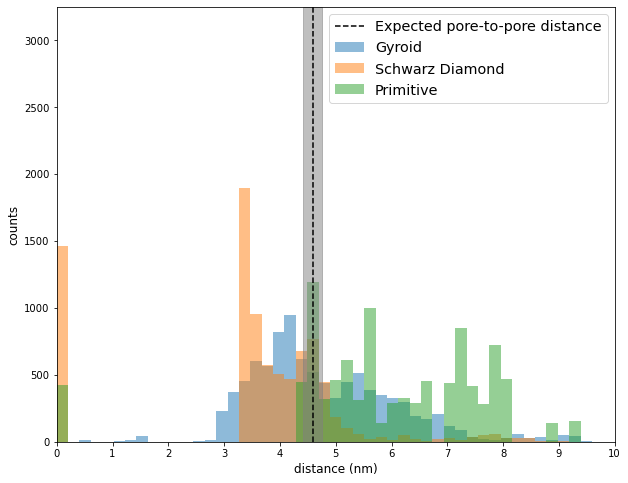

In [44]:
# Plot both histograms with matplotlib
bins = np.linspace(0,10,50)

fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.hist(hist_gyroid['Gyroid'], bins=bins,
        alpha=0.5, label='Gyroid')
ax.hist(hist_schwarzD['SchwarzD'], bins=bins,
        alpha=0.5, label='Schwarz Diamond')
ax.hist(hist_primitive['Primitive'], bins=bins,
       alpha=0.5, label='Primitive')


# Add the bilayer thickness + pore size line
x = np.ones(10)*4.59
y = np.linspace(0,3500,10)
ax.plot(x,y, color='black', linestyle='dashed',label='Expected pore-to-pore distance')
ax.axvspan(4.59 - 0.17, 4.59 + 0.17, color='gray', alpha=0.5)


# Some formatting
ax.set_xlim(0,10)
ax.set_ylim(0,3250)
ax.set_xlabel('distance (nm)',fontsize='large')
ax.set_ylabel('counts',fontsize='large')
ax.set_xticks(np.arange(0,11,1))
ax.legend(fontsize='x-large');

# fig.savefig('dist_compare.png')

Completed gyroid distribution for guess = 2.0
Completed SchwarzD distribution for guess = 2.0
Completed primitive distribution for guess = 2.0

Completed gyroid distribution for guess = 2.5
Completed SchwarzD distribution for guess = 2.5
Completed primitive distribution for guess = 2.5

Completed gyroid distribution for guess = 3.0
Completed SchwarzD distribution for guess = 3.0
Completed primitive distribution for guess = 3.0

Completed gyroid distribution for guess = 3.5
Completed SchwarzD distribution for guess = 3.5
Completed primitive distribution for guess = 3.5

Completed gyroid distribution for guess = 4.0
Completed SchwarzD distribution for guess = 4.0
Completed primitive distribution for guess = 4.0

Completed gyroid distribution for guess = 4.5
Completed SchwarzD distribution for guess = 4.5
Completed primitive distribution for guess = 4.5

Completed gyroid distribution for guess = 5.0
Completed SchwarzD distribution for guess = 5.0
Completed primitive distribution for guess

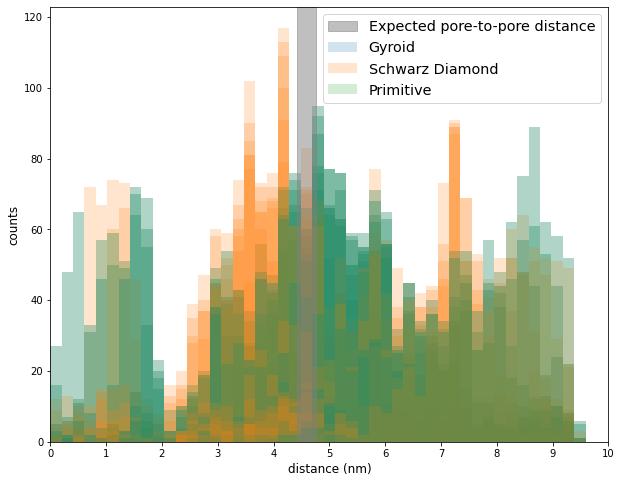

In [47]:
sample = 1000
fig, ax = plt.subplots(1,1, figsize=(10,8))

for g in np.linspace(2,8,13):
        
        dist_gyroid,structs,ps = surface2surface(structure,struct='gyroid',guess=g,box=box,period=period,sample=sample)
        hist_gyroid = pd.DataFrame(dist_gyroid)
        print('Completed gyroid distribution for guess = %.1f' %(g))
        ax.hist(hist_gyroid,bins=bins,alpha=0.2, color='tab:blue')

        dist_schwarzD,structs,ps = surface2surface(structure,struct='schwarzD',guess=g,box=box,period=period,sample=sample)
        hist_schwarzD = pd.DataFrame(dist_schwarzD)
        print('Completed SchwarzD distribution for guess = %.1f' %(g))
        ax.hist(hist_schwarzD,bins=bins,alpha=0.2, color='tab:orange')
        
        dist_primitive,structs,ps = surface2surface(structure,struct='primitive',guess=g,box=box,period=period,sample=sample)
        hist_primitive = pd.DataFrame(dist_primitive)
        print('Completed primitive distribution for guess = %.1f\n' %(g))
        ax.hist(hist_gyroid,bins=bins,alpha=0.2, color='tab:green')
        

#x = np.ones(10)*4.59
#y = np.linspace(0,3000,10)
#ax.plot(x,y, color='black', linestyle='dashed')
ax.axvspan(4.59 - 0.17, 4.59 + 0.17, color='gray', alpha=0.5)

ax.set_xlim(0,10)
#ax.set_ylim(0,1250)
ax.set_xlabel('distance (nm)',fontsize='large')
ax.set_ylabel('counts',fontsize='large')
ax.set_xticks(np.arange(0,11,1))
ax.legend(['Expected pore-to-pore distance','Gyroid','Schwarz Diamond','Primitive'], fontsize='x-large')
# fig.savefig('scan_initial_guess.png')

## Primitive

In [37]:
# Generate the structure
n = 100
box = 9.4 # nm
period = 9.4
x = np.linspace(0,    box, n)
y = np.linspace(0,    box, n)
z = np.linspace(0,    box, n)
X = [x[:,None,None], y[None,:,None], z[None,None,:]]

print('Box size is\t %.4f' %(box))
print('Period is\t %.4f' %(period))

C = Primitive(X, period)

grid = np.zeros([n**3, 3])
count = 0
for i in range(n):
    for j in range(n):
        for k in range(n):
            if -0.01 < C[i,j,k] < 0.01:
                grid[count,:] = [x[i], y[j], z[k]]
                count += 1
                
structure = grid[:count, :]
print('Size of structure:')
print(structure.shape)

df = pd.DataFrame(structure, columns=['x','y','z'])
df['size'] = np.ones(structure.shape[0]) * 0.1

Box size is	 9.4000
Period is	 9.4000
Size of structure:
(5616, 3)


In [42]:
# Generate the points for plotting
sample = 10
guess = 4
box = 9.4
struct = 'primitive'

dist,structs,ps = surface2surface(structure,struct=struct,guess=guess,box=box,period=period,sample=sample)

In [43]:
# Plot with Plotly
# Plot the structure
df = pd.DataFrame(structure, columns=['x','y','z'])
df['size'] = np.ones(structure.shape[0]) * 0.1
fig = px.scatter_3d(df[:],x='x',y='y',z='z', opacity=1, size='size')

for i,p in enumerate(ps):
    # Plot the normal vectors
    cone = Primitive_grad(structure[p,:],period)
    fig.add_trace(
        go.Cone(x=np.array(structure[p,0]), y=np.array(structure[p,1]), z=np.array(structure[p,2]),
        u=np.array(cone[0]),      v=np.array(cone[1]),      w=np.array(cone[2]),
        sizeref=1.25, showscale=False)
    )
    
    x = np.array([structure[p,0],structs[i,0]])
    y = np.array([structure[p,1],structs[i,1]])
    z = np.array([structure[p,2],structs[i,2]])
    
    fig.add_trace(
        go.Scatter3d(
        x=x, y=y, z=z, marker_color='green', marker_size=5
    ))
    
fig.update_layout(showlegend=False)

fig.show()

In [40]:
# Generate the distribution
sample = 10000
box = 9.4
guess = 4.6
struct = 'primitive'

dist_primitive,structs,ps = surface2surface(structure,struct=struct,guess=guess,box=box,period=period,sample=sample)

/Users/nate_schwindt/anaconda3/envs/visualization/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.



In [41]:
# Plot the histogram
hist_primitive = pd.DataFrame(dist_primitive,columns=['Primitive'])
counts, bins = np.histogram(hist_primitive,bins=np.arange(0,10,0.1))
bins = 0.5 * (bins[:-1] + bins[1:])
fig = px.bar(x=bins, y=counts, labels={'x':'surface-to-surface distance (nm)', 'y':'count'},
            title='Primitive')
fig.show()